# Analyse des commentaires
Dans ce notebook, nous allons regarder en détail les commentaires laissés par les utilisateurs.
Le travail sera divisé en deux parties : Construction du corpus et Début ? d'analyse des fréquences

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from reco_systems.filter import filter_df
import reco_systems.text_filtering as ft
from reco_systems.user_game_matrix import center_score
import seaborn as sns

%load_ext autoreload
%autoreload 2

## Partie 1 : Construction corpus

Afin de construire le corpus, nous allons utiliser la fonction ```corpus_construction``` du fichier _text_filtering.py_ Celle-ci prend en paramètre la taille du corpus souhaité et utilise la BDD _lemmas.csv_ afin de récupérer les fréquences d'apparition de chaque lemma. Pour l'instant, nous gardons les $k$ instances les plus fréquentes, où $k$ représente la taille passée en paramètre.

(proposition de modification: ajouter en paramètre le nombre d'apparition minimum de chaque instance sur l'ensemble des avis ?)

In [2]:
corpus2 = ft.construction_corpus(2000)
# corpus5 = ft.construction_corpus(5000)
# corpus10 = ft.construction_corpus(10000)

In [47]:
lemmas = pd.read_csv("generated_data/lemmas.csv", index_col=0)

## Partie 2 : Analyse des fréquences

Maintenant que nous avons créé nos corpus, nous pouvons comparer les champs lexicaux utilisés sur les avis négatifs et positifs. Pour cela, nous devons d'abord séparer les avis en deux catégories. Il est important de centrer les notes afin d'enlever le biais des utilisateurs sur les notes.

In [3]:
# Construction de la BDD avec avis centrés
avis = pd.read_csv("database_cleaned/avis_clean.csv", index_col = 0)
min_reviews = 10
rev_filter = filter_df(avis, min_reviews)
filtered_centrd_data, _= center_score(rev_filter)

11201 10549
2252 2676
1957 2618
1947 2616
1946 2615
1945 2614


In [4]:
# Séparation de la bdd 
positifs = filtered_centrd_data[filtered_centrd_data['Rating'] >=0][['Comment title', 'Comment body']].copy()
negatifs = filtered_centrd_data[filtered_centrd_data['Rating'] <0][['Comment title', 'Comment body']].copy()

In [5]:
print("Nombre d'avis negatif", len(negatifs)/len(filtered_centrd_data))
print("Nombre d'avis positif", len(positifs)/len(filtered_centrd_data))

Nombre d'avis negatif 0.43073353153843763
Nombre d'avis positif 0.5692664684615624


In [6]:
# lem = pd.read_csv("generated_data/lemmas.csv")[['Comment line', 'Lemma']]
# lem['Lemma'] = lem['Lemma'].apply(lambda val : " " if type(val) != str else val )
# lem = lem.groupby(by='Comment line').apply(lambda row : " ".join(row["Lemma"])) 
# lem = lem.to_frame()
# lem.columns = ['Comment']
# lem.to_csv("generated_data/avis_lemmatized.csv")

À partir de là, nous pouvons appliquer la fonction ```word_freq``` qui calcul la fréquence de chaque lemma dans chaque dataframe des avis.

In [7]:
fpos = ft.words_freq(positifs, corpus2)
fneg = ft.words_freq(negatifs, corpus2)

In [12]:
fpos = fpos.sort_values(by=['Freq'], ascending = False)
fneg = fneg.sort_values(by=['Freq'], ascending = False)

Text(0.5, 1.0, "Fréquence des Lemmas par type d'avis : corpus 2000")

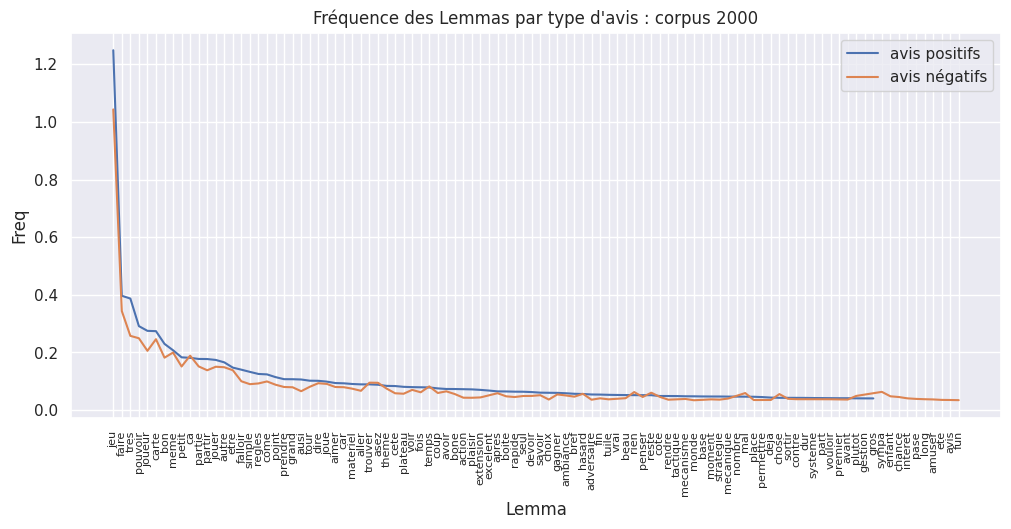

In [104]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
ax = sns.lineplot(fpos.head(90),x='Lemma',y='Freq',label='avis positifs')
ax = sns.lineplot(fneg.head(90),x='Lemma',y='Freq',label='avis négatifs')
ax.tick_params(axis='x', rotation=90, labelsize=8)
ax.set_title("Fréquence des Lemmas par type d'avis : corpus 2000")

On peut remarquer qu'à certains endroit, il existe des écarts de fréquence beaucoup plus prononcés qu'à d'autres. Afin de mieux les voir, nous pouvons utiliser la fonction ```diff_freq```. Elle retourne un dataframe avec, pour chaque lemma $l$, la différence entre la fréquence de $l$ dans les avis positifs et celle dans les avis négatifs. Ainsi, la différence de fréquence sera positive si $l$ apparaît plus souvent dans les avis positifs et que négatifs, et vice versa.

Le DataFrame retourné est trié par différence de fréquence décroissante.

In [31]:
fdiff = ft.diff_freq(fpos,fneg) # si valeur >= 0, alors + grande frequence dans fpos que fneg 
fdiff

,Lemma,Freq differency
30673,jeu,0.205292
57127,tres,0.129466
31092,joueur,0.069317
22318,faire,0.052982
21543,excelent,0.050154
...,...,...
48505,repetitif,-0.013907
34669,manque,-0.014326
17428,domage,-0.014892
29848,interet,-0.018720


On remarque que pour 2000 mots, tous les mots dans fpos sont aussi dans fneg

Text(0.5, 1.0, 'Différence de fréquences : 50 mots + notables avis positifs : corpus 2000')

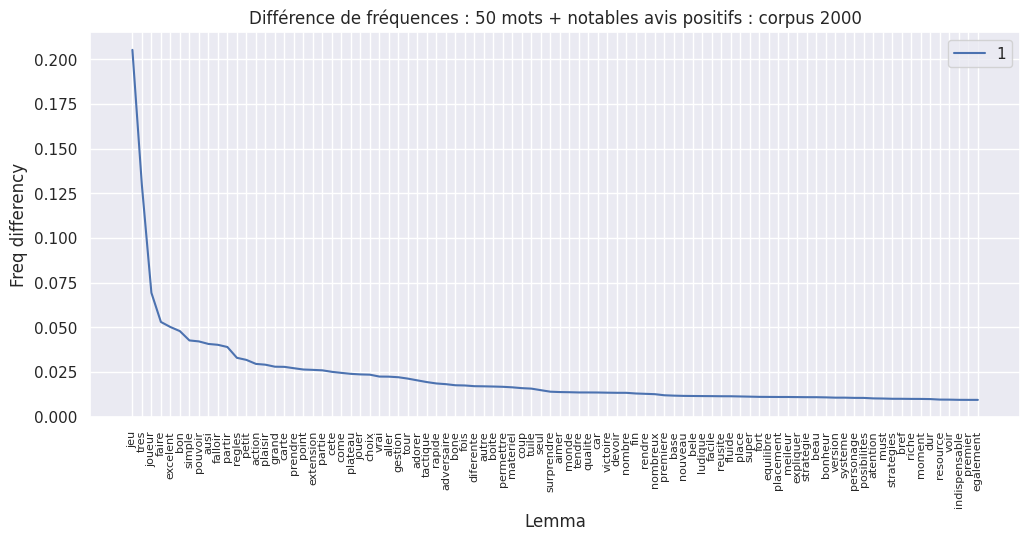

In [103]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
ax = sns.lineplot(fdiff.head(90), x='Lemma',y='Freq differency', label='1')
ax.tick_params(axis='x', rotation=90, labelsize=8)
ax.set_title("Différence de fréquences : 50 mots + notables avis positifs : corpus 2000")

Text(0.5, 1.0, 'Différence de fréquence : 50 mots + notables avis négatifs : corpus 2000')

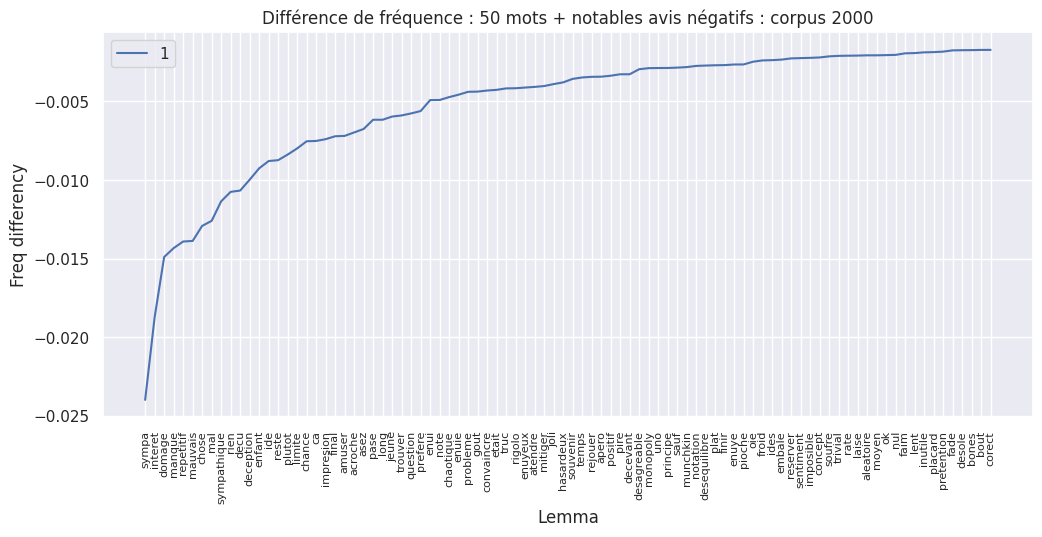

In [102]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
ax = sns.lineplot(fdiff.tail(90)[::-1], x='Lemma',y='Freq differency', label='1')
ax.tick_params(axis='x', rotation=90, labelsize=8)
ax.set_title("Différence de fréquence : 50 mots + notables avis négatifs : corpus 2000")

Zoom sur les différences de fréquence


Text(0.5, 1.0, 'Différence de fréquence sur les pires mots : corpus 2000')

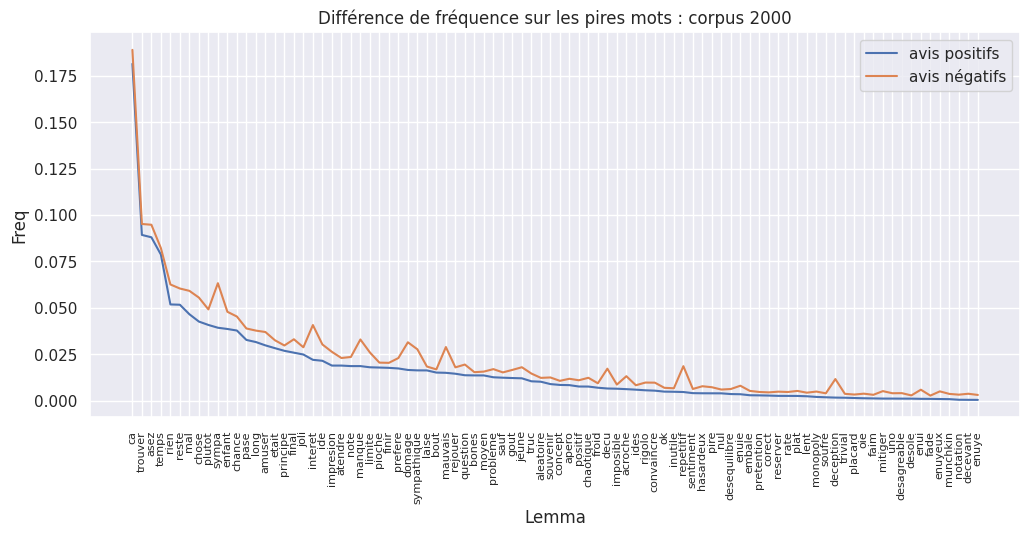

In [101]:
lemmas_neg = fdiff.tail(90)['Lemma'].to_numpy()
pos_tail = fpos[fpos['Lemma'].isin(lemmas_neg)]
neg_tail = fneg[fneg['Lemma'].isin(lemmas_neg)]

ax = sns.lineplot(pos_tail, x='Lemma', y='Freq', label='avis positifs')
ax = sns.lineplot(neg_tail, x='Lemma', y='Freq', label='avis négatifs')
ax.tick_params(axis='x', rotation=90, labelsize=8)
ax.set_title("Différence de fréquence sur les pires mots : corpus 2000")

Text(0.5, 1.0, 'Différence de fréquence sur les meilleurs mots : corpus 2000')

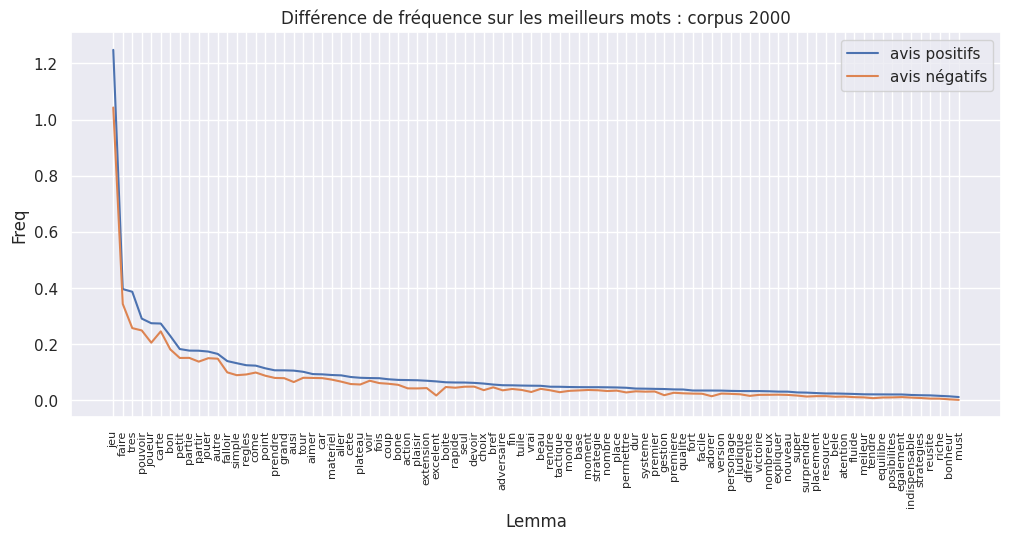

In [100]:
lemmas_neg = fdiff.head(90)['Lemma'].to_numpy()
pos_head = fpos[fpos['Lemma'].isin(lemmas_neg)]
neg_head = fneg[fneg['Lemma'].isin(lemmas_neg)]

ax = sns.lineplot(pos_head, x='Lemma', y='Freq', label='avis positifs')
ax = sns.lineplot(neg_head, x='Lemma', y='Freq', label='avis négatifs')
ax.tick_params(axis='x', rotation=90, labelsize=8)
ax.set_title("Différence de fréquence sur les meilleurs mots : corpus 2000")

Visualisation par types de mots

In [54]:
lemmas_sp = lemmas[~lemmas["Lemma"].isna()]
lemmas_sp = lemmas_sp[lemmas_sp['Part of speech'].isin(['ADJ', 'NOM', "VER:infi","VER:pper", "VER:pres"])]
lemmas_sp_np = lemmas_sp[['Lemma', "Part of speech"]].to_numpy()

In [60]:
lemma_speech = lemmas_sp[['Lemma', 'Part of speech']]

In [ ]:
lemma_speech['Part of speech'].unique()

array(['NOM', 'ADJ', 'VER:infi', 'VER:pper', 'VER:pres'], dtype=object)

In [ ]:
# get only verbs
lemma_verb = lemma_speech[lemma_speech['Part of speech'].isin(['VER:infi', 'VER:pper', 'VER:pres'])]
fdiff_verb = fdiff[fdiff['Lemma'].isin(lemma_verb['Lemma'].unique())].sort_values(by=['Freq differency'], ascending=False)
lemma_verb['Lemma'].unique()

array(['rejouer', 'revivre', 'lorsqu', ..., 'rapidesjoli', 'adversaitre',
       'resoue'], dtype=object)

In [109]:
fdiff_verb.shape

(295, 2)

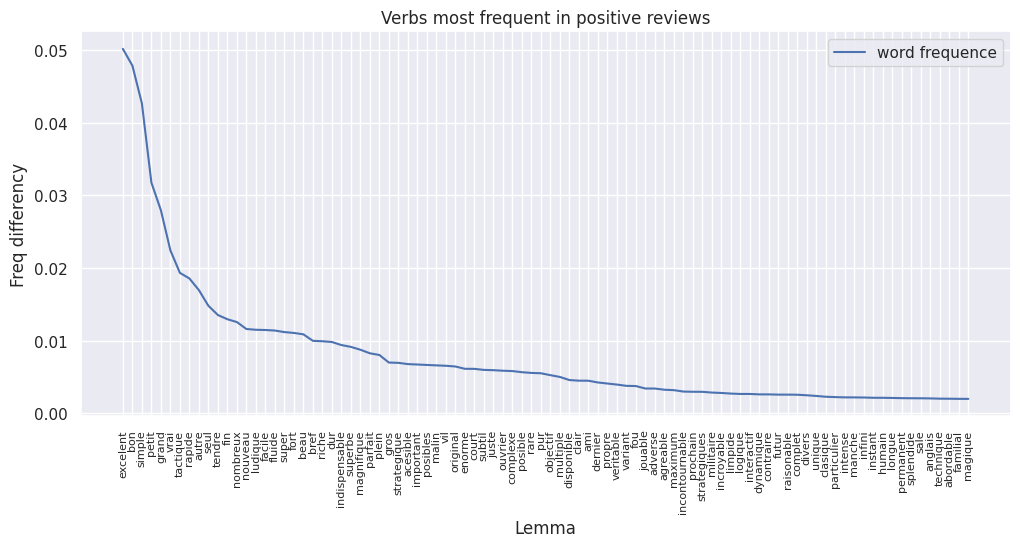

In [99]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
ax = sns.lineplot(fdiff_verb.head(90), x='Lemma',y='Freq differency', label='word frequence')
plt.title("Verbs most frequent in positive reviews")
ax.tick_params(axis='x', rotation=90, labelsize=8)

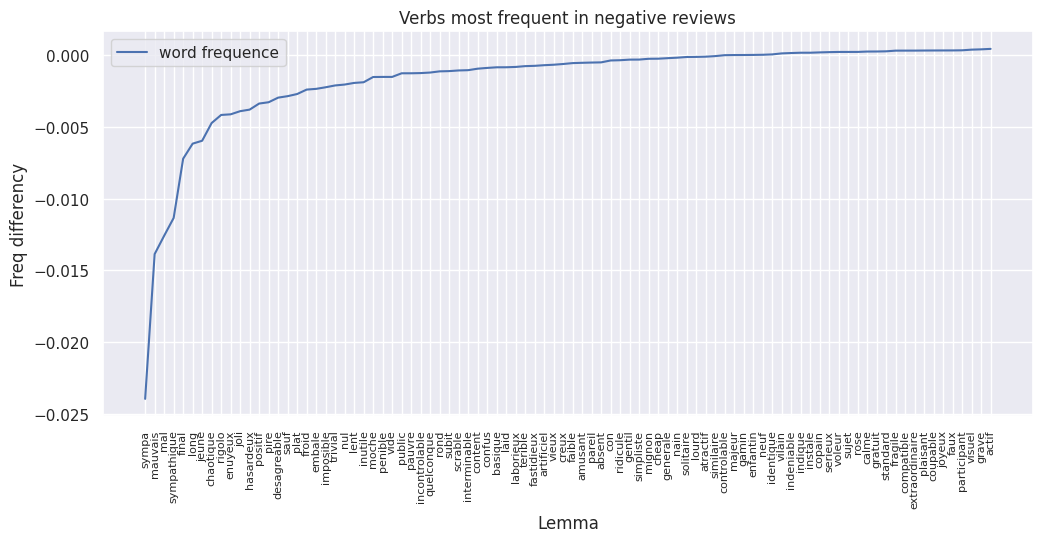

In [98]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
ax = sns.lineplot(fdiff_verb.tail(90)[::-1], x='Lemma',y='Freq differency', label='word frequence')
plt.title("Verbs most frequent in negative reviews")
ax.tick_params(axis='x', rotation=90, labelsize=8)

In [ ]:
# get only adj
lemma_adj = lemma_speech[lemma_speech['Part of speech'].isin(['ADJ'])]
fdiff_adj = fdiff[fdiff['Lemma'].isin(lemma_adj['Lemma'].unique())].sort_values(by=['Freq differency'], ascending=False)
lemma_adj['Lemma'].unique()

array(['bon', 'joli', 'sensible', ..., 'formaidable', 'jaux', 'bauzales'],
      dtype=object)

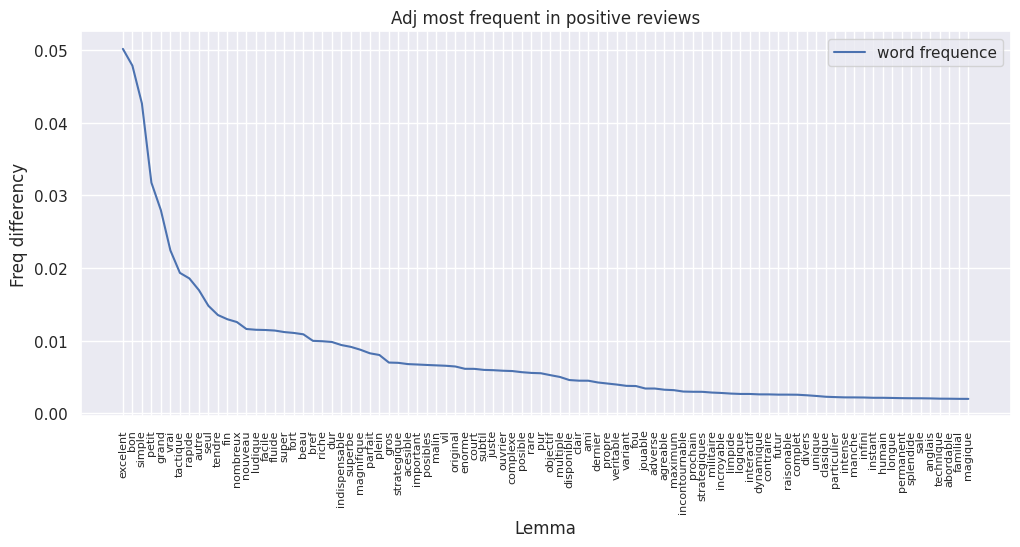

In [ ]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
ax = sns.lineplot(fdiff_adj.head(90), x='Lemma',y='Freq differency', label='word frequence')
plt.title("Adj most frequent in positive reviews")
ax.tick_params(axis='x', rotation=90, labelsize=8)

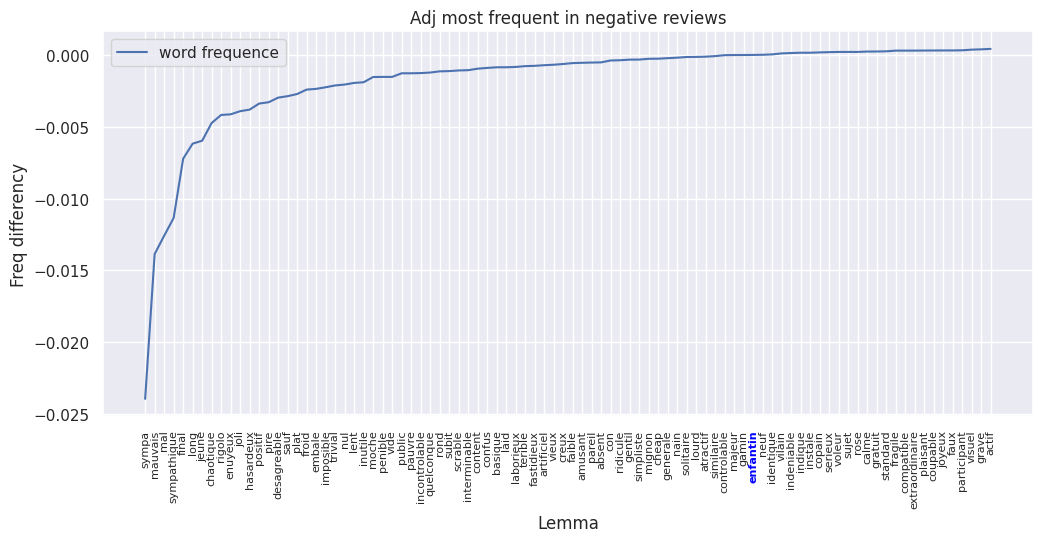

In [ ]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
ax = sns.lineplot(fdiff_adj.tail(90)[::-1], x='Lemma',y='Freq differency', label='word frequence')
plt.title("Adj most frequent in negative reviews")
ax.tick_params(axis='x', rotation=90, labelsize=8)

# color one label
for label, position in zip(ax.get_xticklabels(), ax.get_xticks()):
    if label.get_text() == 'enfantin':
        label.set_color("blue")
        label.set_fontweight('bold')

In [106]:
# get only nom
lemma_nom = lemma_speech[lemma_speech['Part of speech'].isin(['NOM'])]
fdiff_nom = fdiff[fdiff['Lemma'].isin(lemma_nom['Lemma'].unique())].sort_values(by=['Freq differency'], ascending=False)
lemma_nom['Lemma'].unique()

array(['voyage', 'aile', 'papilon', ..., 'defensebref', 'acrochele',
       'miral'], dtype=object)

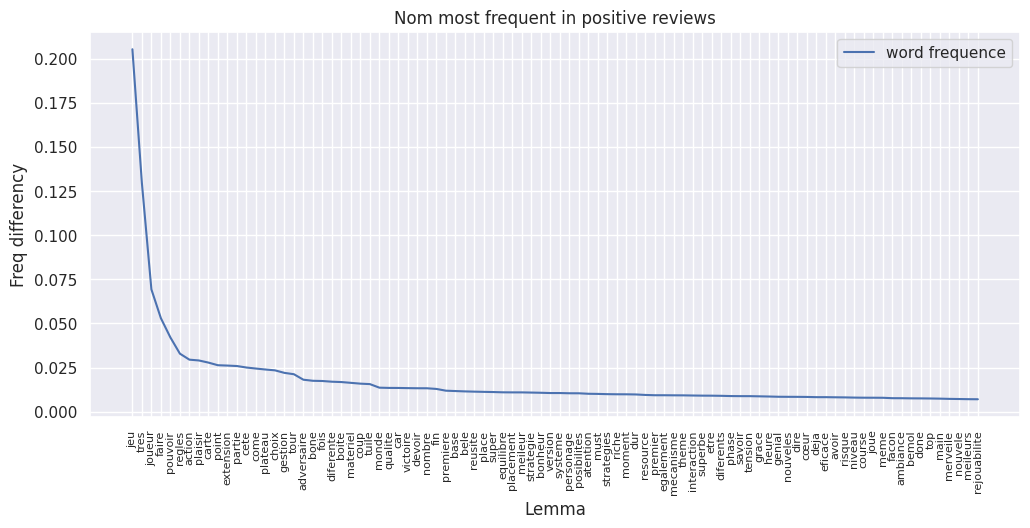

In [107]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
ax = sns.lineplot(fdiff_nom.head(90), x='Lemma',y='Freq differency', label='word frequence')
plt.title("Nom most frequent in positive reviews")
ax.tick_params(axis='x', rotation=90, labelsize=8)

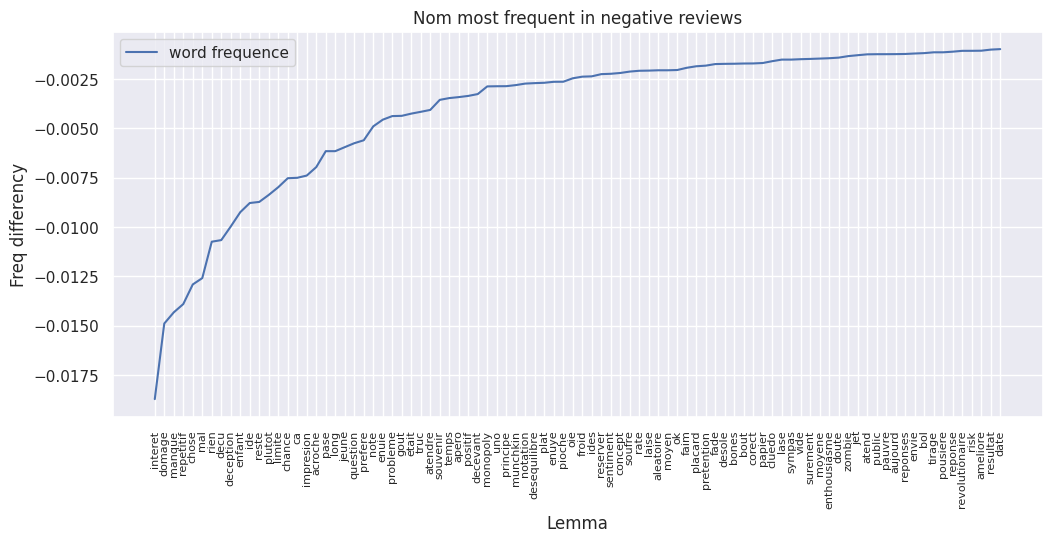

In [108]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
ax = sns.lineplot(fdiff_nom.tail(90)[::-1], x='Lemma',y='Freq differency', label='word frequence')
plt.title("Nom most frequent in negative reviews")
ax.tick_params(axis='x', rotation=90, labelsize=8)

In [114]:
# vocabulary + - difference
fdiff[fdiff["Freq differency"] >0].shape, fdiff[fdiff["Freq differency"] <=0].shape

((1663, 2), (337, 2))

See most and less rated games vocabulary 

In [186]:
# sort games by ratings rank
rank_game = rev_filter[["Game id", "Rating"]].groupby("Game id").mean().sort_values(by="Rating", ascending=False)
rank_game.head(), rank_game.tail()

(            Rating
 Game id           
 7733     10.000000
 6678      9.833333
 8821      9.800000
 9669      9.700000
 9210      9.600000,
            Rating
 Game id          
 440      2.545455
 5476     2.481481
 2099     2.430000
 4916     2.390000
 1928     2.000000)

In [187]:
rev_filter[rev_filter["Game id"] == 1928]

,Game id,User id,Game name UI,Username,Datetime,Rating,Comment title,Comment body
56094,1928,1,Conan : le jeu de cartes,morlockbob,2014-12-09 09:43:56,1.0,Exploiter la licence....et le joueur,Pour 2015 Edge fera-t-il l'effort de proposer ...
56095,1928,2386,Conan : le jeu de cartes,zatistine,2012-09-09 12:29:05,0.0,Hyperboraté,Il m'aura suffit d'une demi-partie pour être d...
56096,1928,339,Conan : le jeu de cartes,adel10,2011-10-29 12:29:02,4.0,dans ta face,je vais faire simple et non constructifaucun i...
56097,1928,1820,Conan : le jeu de cartes,guilou05,2013-02-25 11:44:03,2.0,À quand un vrai jeu dans l'univers de Conan?,Je l'attendais beaucoup. Je suis un fan de Con...
56098,1928,7,Conan : le jeu de cartes,Jones,2012-07-28 12:29:05,0.0,Et il ne devint pas roi du tout,Le jeu où l'on peut gagner dès le premier tour...
56099,1928,4321,Conan : le jeu de cartes,aurelh,2011-10-22 12:29:02,4.0,La chute du voleur,Commençons par les bons côtés: les illustartio...
56100,1928,108,Conan : le jeu de cartes,shaudron,2012-12-12 11:18:24,2.0,Trahison !,Conan est ma licence préférée. Je suis fan de ...
56101,1928,1947,Conan : le jeu de cartes,MrSel,2011-10-13 12:29:02,2.0,Entre ça et pousser une roue d'esclaves...,"Les illustrations sont superbes, les citations..."
56102,1928,883,Conan : le jeu de cartes,honnis rime,2016-03-03 09:37:20,0.2,non conan t en vas pas!!!!!!,c est du grand n importe quoi
56103,1928,2304,Conan : le jeu de cartes,lalouz,2011-09-29 12:29:02,2.0,Quelle déception... !!!,"La vieille blague pourrie de ""Conan le Barban""..."


In [188]:
top_5 = rev_filter[rev_filter["Game id"].isin(rank_game.head(6).index)][["Game id", "Comment body"]]
top_5['Comment body'] = top_5['Comment body'].apply(lambda row : row.split())
top_5 = top_5.explode(column='Comment body')
top_5 = top_5[top_5["Comment body"].isin(corpus2)]
top_5

,Game id,Comment body
19196,2583,mal
19196,2583,extension
19196,2583,content
19196,2583,avoir
19197,2583,avoir
...,...,...
104227,9669,jeu
104227,9669,monde
104227,9669,un
104227,9669,jeu


In [189]:
# word frequencies for these games
def word_frequencies(group):
    words = group['Comment body'].values
    val, nb = np.unique(words, return_counts=True)
    return pd.Series(val, index=nb/np.sum(nb))

result = top_5.groupby('Game id').apply(word_frequencies).reset_index(name="word").rename(columns={'level_1': 'freq'})
result

/tmp/ipykernel_8530/40335655.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = top_5.groupby('Game id').apply(word_frequencies).reset_index(name="word").rename(columns={'level_1': 'freq'})


,Game id,freq,word
0,2583,0.007692,acheter
1,2583,0.007692,acquérir
2,2583,0.007692,aller
3,2583,0.007692,amateur
4,2583,0.007692,augmenter
...,...,...,...
549,9669,0.021277,version
550,9669,0.010638,victoire
551,9669,0.005319,vie
552,9669,0.010638,voir


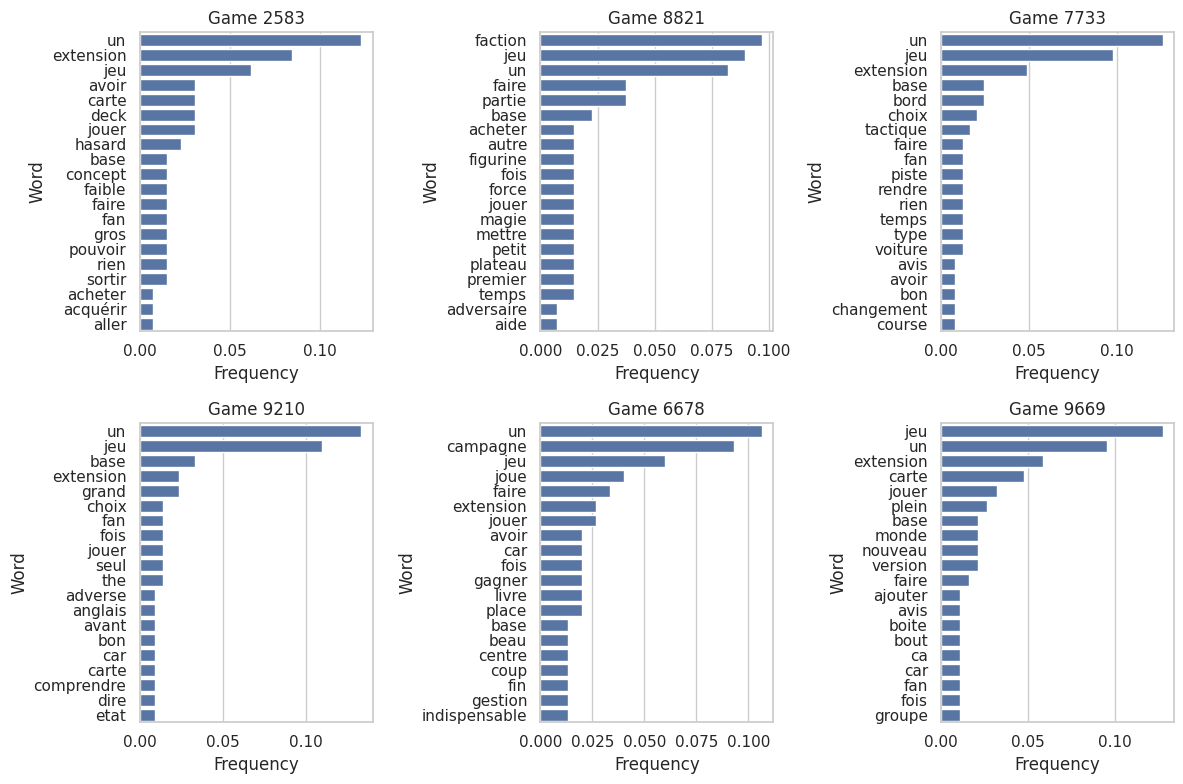

In [197]:
sns.set(style="whitegrid")

# Create a figure to hold multiple subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# Loop through each game and plot
for i, game_id in enumerate(top_5['Game id'].unique()):
    
    game_words = result[result['Game id'] == game_id][["word", "freq"]]
    
    ax = axes[i // 3, i % 3]
    #game_words.nlargest(10, columns="freq").plot(kind='barh', color='skyblue', ax=ax)
    sns.barplot(x='freq', y='word', data=game_words.nlargest(20, columns="freq"), ax=ax)
    
    # Set plot title and labels
    ax.set_title(f"Game {game_id}")
    ax.set_ylabel('Word')
    ax.set_xlabel('Frequency')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [191]:
folder = "database_cleaned"
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)

In [ ]:
for id in result["Game id"].unique():
    print(id, jeux_clean.iloc[id]["Type"], jeux_clean.iloc[id]["Game name website"])

2583 nan dominion-age-des-tenebres-0
6678 Jeux de plateau memoire-44-carnets-de-campagne-vol-1
7733 nan rallyman-dirt
8821 Jeu de carte à collectionner|Jeux de cartes summoner-wars-le-royaume-dechu
9210 Jeux de cartes the-new-era
9669 Jeux de plateau twilight-imperium-shattered-empire


We can categorize the games that have NaN categories, 

-> rallyman-dirt is about cars and race

-> dominion-age-des-tenebres-0 games with cards, kingdoms, battle, is an extension